# Example: Iris classifier

![Iris Flower](./images/iris-dataset.png)

In [1]:
#Load packages
import os
import mlflow 
from mlflow_for_ml_dev.experiments.exp_utils import get_or_create_experiment
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Loading and Exploring Dataset

In [2]:
## Load data
data = load_iris(as_frame=True)

In [3]:
data.data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [4]:
data.target

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: target, Length: 150, dtype: int32

In [5]:
print(data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [6]:
# split dataset into training and testing data
x_train, x_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42)

## Creating the Experiment

In [7]:
name = "iris-classifier"
experiment = get_or_create_experiment(
    experiment_name=name,
    tags={
            "mlflow.note.content": "iris dataset classification experiment",
            "project_name":"iris_classifier",
            "task": "classification",
            "topic": "run_management",
        }
    )


## Modelling

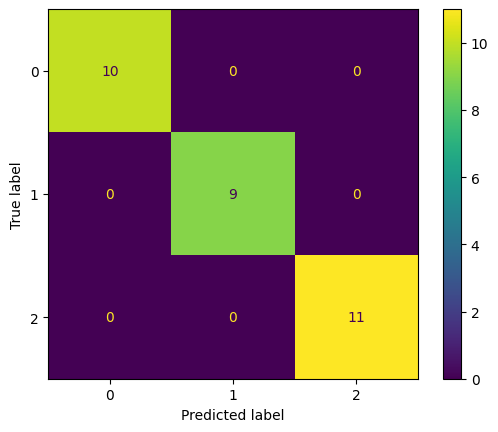

In [8]:
#create instance of random forest classifier
rfc = RandomForestClassifier()

# train model
rfc.fit(x_train, y_train)

# predict
y_pred = rfc.predict(x_test)

classification_report_ = classification_report(y_test, y_pred, output_dict=True)
accuracy_score = balanced_accuracy_score(y_test, y_pred)
confusion_matrix = ConfusionMatrixDisplay.from_estimator(rfc, x_test, y_test)


In [9]:
accuracy_score

1.0

In [10]:
type(confusion_matrix.figure_)

matplotlib.figure.Figure

In [11]:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [12]:
# # start mlflow run
with mlflow.start_run(run_name = "iris_classifier", experiment_id=experiment.experiment_id) as run:

    print("Run ID:", run.info.run_id)

    # log metrics as json file
    mlflow.log_dict(classification_report_, "files/classification_report.json")
    
    # log metrics
    mlflow.log_metric("accuracy", accuracy_score)

    # log figure 
    mlflow.log_figure(confusion_matrix.figure_, "confusion_matrix.png")

    # log params
    mlflow.log_params(rfc.get_params())

    # log model
    mlflow.sklearn.log_model(sk_model=rfc, artifact_path="model")

Run ID: 603c8ff295d14dcc9bdc39841f3e3b14


2024/11/02 16:36:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


**Get first estimators plots**

In [ ]:
# code taken from this post https://stackoverflow.com/questions/40155128/plot-trees-for-a-random-forest-in-python-with-scikit-learn
n_estimators = 2
fn = data.feature_names
cn = data.target_names
fig, axes = plt.subplots(nrows = 1,ncols = n_estimators,figsize = (10,2), dpi=900)
for index in range(0, n_estimators):
    tree.plot_tree(rfc.estimators_[index],
                   feature_names = fn, 
                   class_names=cn,
                   filled = True,
                   ax = axes[index])

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)


# create directory for artifacts
os.makedirs('./artifacts_example', exist_ok=True)

# save figure
fig.savefig('./artifacts_example/rf_5trees.png')

**Get feature Importance Plot**

In [ ]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
forest_importances = pd.Series(importances, index=fn)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# save figure
fig.savefig("./artifacts_example/feature_importance.png")

In [ ]:
x_test["target"] = y_test
x_test["prediction"] = y_pred

# save predictions
x_test.to_csv("./artifacts_example/predictions.csv", index=False)

In [ ]:
# log artifacts
with mlflow.start_run(run_id=run.info.run_id, experiment_id=experiment.experiment_id):

    # Log individual artifacts
    mlflow.log_artifact(local_path = "./artifacts_example/rf_5trees.png", artifact_path="artifacts")
    mlflow.log_artifact(local_path = "./artifacts_example/feature_importance.png", artifact_path="artifacts")
    mlflow.log_artifact(local_path = "./artifacts_example/predictions.csv", artifact_path="artifacts")

    # Log all artifacts in a directory
    mlflow.log_artifacts(local_dir = "./artifacts_example", artifact_path="all_artifacts")